In [70]:
import numpy as np
import math as m
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.core.interactiveshell import InteractiveShell

from pandas.plotting import scatter_matrix

from sklearn.metrics import confusion_matrix

from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import PolynomialFeatures

import graphviz
import lime
import xgboost as xgb
InteractiveShell.ast_node_interactivity = "all"

In [135]:
#############################################################
# Pipeline for train.csv
#############################################################
def pipeline(data):
    # Drop empty columns
    garbage = ['F25', 'F26', 'F27']
    #if garbage in data.columns:
    data.drop(garbage, axis=1, inplace=True)
            
    # Drop columns with very low correlation to label
    #low_corr = ['F20', 'F23', 'F21', 'F18', 'F1', 'F24', 'F4',
    #        'F11', 'F13', 'F2', 'F15', 'F8', 'F14', 'F22']
    #data.drop(low_corr, axis=1, inplace=True)
    data.drop(['id'], axis=1, inplace=True)
    
    # Drop duplicate columns
    dups = ['F9', 'F12']
    data.drop(dups, axis=1, inplace=True)

    # F6
    #for i in range(10):
    #    data_point = data['F6'].idxmax()
    #    data.drop([data_point], inplace=True)
    data.F6 = np.log(data.F6)

    # F16
    data = data[data['F16'] > 115000]
    data.F16 -= data.F16.min()
    data.F16 /= m.sqrt(data.F16.std())

    # F20
    #data = data[data.F20 != 12]
    
    # F3
    data.F3 += 1
    data.F3 = np.log(data.F3)
    
    # F4
    #data.F4 -= data.F4.mean()
    #data.F4 /= m.sqrt(data.F4.std())
    
    # F5
    data = data[data.F5 < 180000]
    data.F5 -= data.F5.min()
    data.F5 /= m.sqrt(data.F5.std())
    
    # F7
    column = 'F7'
    #data.loc[data[column] < 75000, column] = 1
    #data.loc[(data[column] < 215000) & (data[column] > 2), column] = 2
    #data.loc[data[column] > 215000, column] = 3
    
    
    # F10
    column = 'F10'
    data = data[data[column] < 200000]
    data = data[data[column] > 120000]
    data.F10 -= data.F10.min()
    data.F10 /= m.sqrt(data.F10.std())
    
    # F17
    column = 'F17'
    data.F17 -= data.F17.min()
    data.F17 /= m.sqrt(data[column].std())
    
    # F19
    data = data[data.F19 < 300000]
    data.F19 /= m.sqrt(data.F19.std())
    
    return data

#############################################################
# Pipeline for test.csv
#############################################################
def testPipeline(data):
     # Drop columns with very low correlation to label
    #low_corr = ['F20', 'F23', 'F21', 'F18', 'F1', 'F24', 'F4',
    #        'F11', 'F13', 'F2', 'F15', 'F8', 'F14', 'F22']
    #data.drop(low_corr, axis=1, inplace=True)
    data.drop(['id'], axis=1, inplace=True)
    
       # Drop duplicate columns
    dups = ['F9', 'F12']
    data.drop(dups, axis=1, inplace=True)

    # F6
    #for i in range(10):
    #    data_point = data['F6'].idxmax()
    #    data.drop([data_point], inplace=True)
    data.F6 = np.log(data.F6)

    # F16
    #data = data[data['F16'] > 115000]
    data.F16 -= data.F16.min()
    data.F16 /= m.sqrt(data.F16.std())

    # F20
    #data = data[data.F20 != 12]
    
    # F3
    data.F3 += 1
    data.F3 = np.log(data.F3)
    
    # F4
    #data.F4 -= data.F4.mean()
    #data.F4 /= m.sqrt(data.F4.std())
    
    # F5
    #data = data[data.F5 < 180000]
    data.F5 -= data.F5.min()
    data.F5 /= m.sqrt(data.F5.std())
    
    # F7
    column = 'F7'
    #data.loc[data[column] < 75000, column] = 1
    #data.loc[(data[column] < 215000) & (data[column] > 2), column] = 2
    #data.loc[data[column] > 215000, column] = 3
    
    
    # F10
    column = 'F10'
    #data = data[data[column] < 200000]
    #data = data[data[column] > 120000]
    data.F10 -= data.F10.min()
    data.F10 /= m.sqrt(data.F10.std())
    
    # F17
    column = 'F17'
    data.F17 -= data.F17.min()
    data.F17 /= m.sqrt(data[column].std())
    
    # F19
    #data = data[data.F19 < 300000]
    data.F19 /= m.sqrt(data.F19.std())
    
    return data

#############################################################
# Writes a file for Kaggle Submission
#############################################################
def makeFile(pred, filename):
    new_index = np.arange(16384,32769,1)
    id_col = pd.DataFrame(new_index, columns=['id'], dtype='int32')
    y_hat = pd.DataFrame(pred, columns=['Y'])
    frames = [id_col, y_hat]
    pred = pd.concat(frames, axis=1)
    pred.to_csv(filename, encoding='utf-8', index=False)

In [145]:
#############################################################
# Pipeline 2 for train.csv
#############################################################
def pipeline2(data):
    data = pipeline(data)
    features, labels = splitData(data)
    poly = PolynomialFeatures(2)
    return poly.fit_transform(features), labels

#############################################################
# Test Pipeline 2 for train.csv
#############################################################
def testPipeline2(data):
    data = testPipeline(data)
    poly = PolynomialFeatures(2)
    return poly.fit_transform(data)

In [17]:
def zeroMean(data, column):
    data[column] -= data[column].mean()
    data[column] /= m.sqrt(data[column].std())
    return data

def dropKLargest(data, column, k):
    for i in range(k):
        data_point = data[column].idxmax()
        data.drop([data_point], inplace=True)

# TODO        # check this functionality
def dropLargestBound(data, column, bound):
    data_point = data[column].idxmax()
    print(data.iloc[data_point][column])
    while(data.iloc[data_point][column] > bound):
        data.drop([data_point], axis=0, inplace=True)
        data_point = data[column].idxmax()
        print(data_point)

# Assumes id column has already been stripped
def splitData(data):
    labels = data['Y']
    features = data.drop(['Y'], axis=1)
    return features, labels

def pltHist(data, column, num_bins=50):
    _ = plt.hist(data[column], num_bins, normed=1, facecolor='green', alpha = 0.5)
    _ = plt.xlabel(column)
    _ = plt.title('Histogram of {}'.format(column))

In [137]:
filename = 'train.csv'
filepath = ''
data = pd.read_csv(filepath + filename)

# Gradient Boosting

In [22]:
features, labels = splitData(new_data)

In [64]:
# Some 5 Fold CV
depths = np.arange(3,15,1)
scores = np.empty((len(depths), 2))
count = 0
for depth in depths:
    accuracy = [] 
    for i in range(5):
        X_train, X_test, y_train, y_test = train_test_split(features, labels)
        clf = GradientBoostingClassifier(loss='exponential', learning_rate=0.1, 
                                 n_estimators=500, max_depth=depth)
        _ = clf.fit(X_train, y_train)
        accuracy.append(clf.score(X_test, y_test))
        #print(accuracy)
    accuracies = np.array(accuracies)
    scores[count, 0] = np.mean(accuracies, axis=0)
    scores[count, 1] = np.std(accuracies, axis=0)
    count += 1

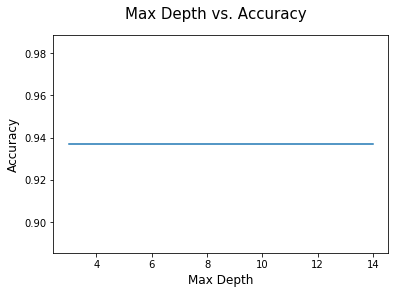

In [65]:
_ = plt.plot(depths, scores[:,0], label="Fold {}".format(i))
_ = plt.xlabel("Max Depth", fontsize=12)
_ = plt.ylabel("Accuracy", fontsize=12)
_ = plt.suptitle("Max Depth vs. Accuracy", fontsize=15)

In [68]:
clf = GradientBoostingClassifier(loss='exponential', learning_rate=0.1, 
                                 n_estimators=500, max_depth=6, subsample=0.5)
_ = clf.fit(features, labels)
test_data = pd.read_csv('test.csv')
test_data = testPipeline(test_data)
pred = clf.predict(test_data)
makeFile(pred, 'prediction-pipelined-gradboost.csv')

#### Lets try some polynomial data

In [138]:
poly_data, labels = pipeline2(data)

/mnt/c/programming/Kaggle-Midterm/lib/python3.5/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [139]:
clf = GradientBoostingClassifier(loss='exponential', learning_rate=0.1, 
                                 n_estimators=500, max_depth=6, subsample=0.5)
_ = clf.fit(poly_data, labels)

In [146]:
test_data = pd.read_csv('test.csv')
test_data = testPipeline2(test_data)
pred = clf.predict(test_data)
makeFile(pred, 'prediction-pipelined-polynomial-gradboost.csv')

That one didnt do very well either.

## A different direction
Lets polynomial fit all the features and drop the ones that have less than one percent correlation with the labels.

In [163]:
data = pd.read_csv('train.csv')

In [164]:
data = pipeline(data)
features, labels = splitData(data)
poly = PolynomialFeatures(2)
poly_data = poly.fit_transform(features)
poly_data = pd.DataFrame(poly_data[1:,1:])
frames = [labels, poly_data]
full_poly_data = pd.concat(frames, axis=1)

/mnt/c/programming/Kaggle-Midterm/lib/python3.5/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


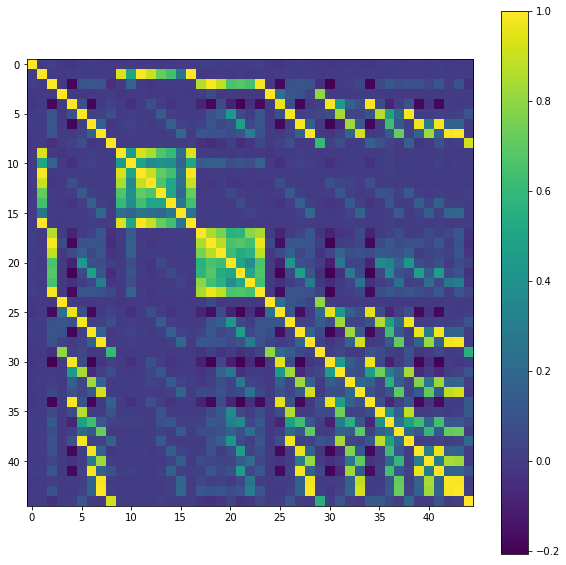

In [165]:
fig, ax = plt.subplots(figsize=(10,10))
_ = plt.imshow(full_poly_data.corr())
_ = plt.colorbar()

In [167]:
corr_matrix = full_poly_data.corr()
print(corr_matrix['Y'].sort_values(ascending=False))

Y     1.000000
1     0.019511
17    0.019103
22    0.018806
16    0.018035
18    0.015265
20    0.015088
19    0.013773
21    0.013420
38    0.012849
35    0.011926
40    0.010355
5     0.010187
14    0.010089
26    0.009978
34    0.006724
9     0.005684
36    0.005186
4     0.004446
13    0.003842
25    0.003689
37    0.003345
43    0.002858
6     0.002775
27    0.002741
8     0.002506
11    0.002241
42    0.002104
10    0.002040
15    0.001712
39    0.001439
0     0.001362
41   -0.000291
7    -0.000297
32   -0.001246
23   -0.002102
28   -0.002116
2    -0.002178
31   -0.002663
30   -0.003547
12   -0.003996
33   -0.013180
3    -0.014116
29   -0.014784
24   -0.015610
Name: Y, dtype: float64
